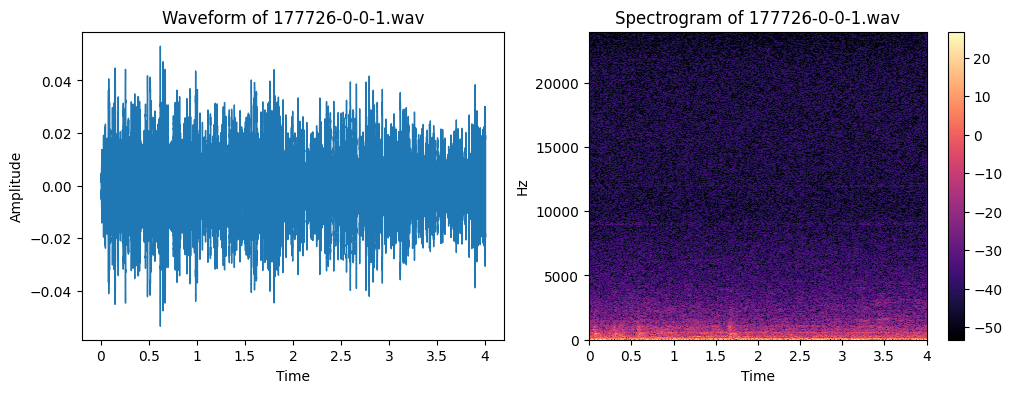

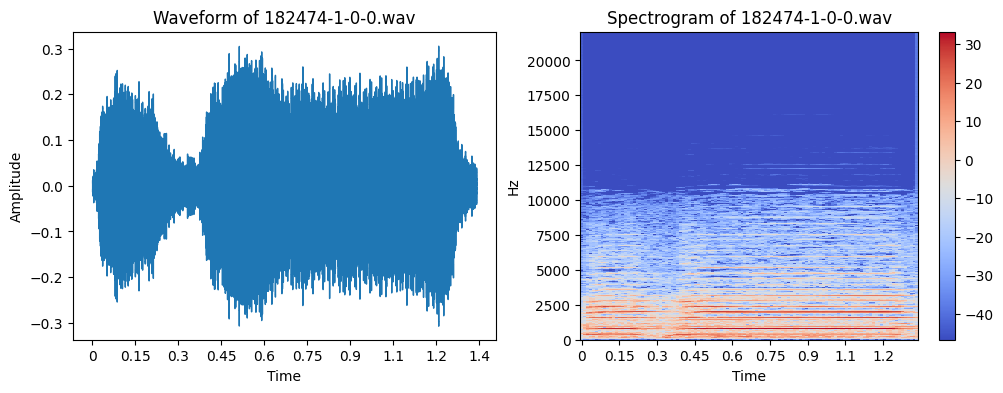

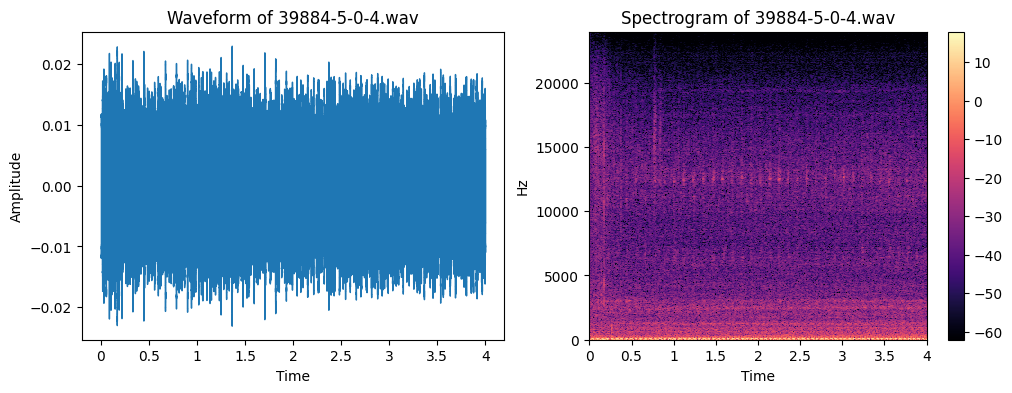

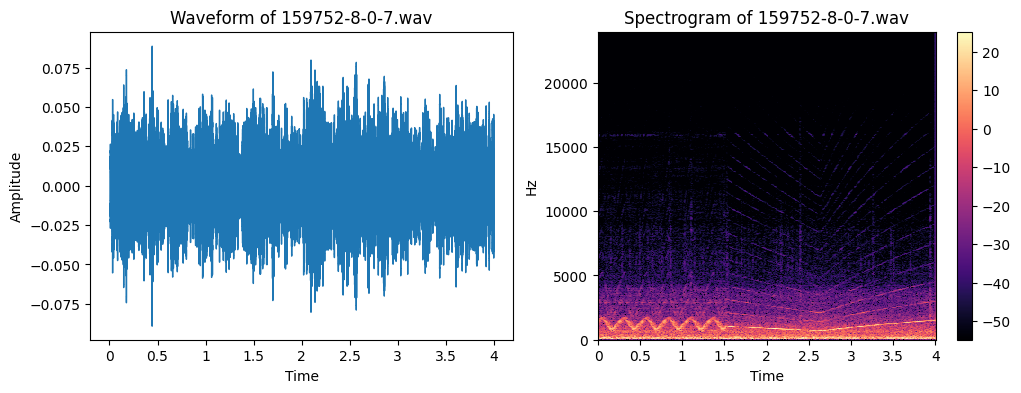

In [1]:
import os
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt

meta_data = pd.read_csv('data/meta.csv')

def plot_audio_files(row):
    filepath = os.path.join('data', row['label'], row['file'])
    data, sr = librosa.load(filepath, sr=None)  # Load with original sample rate

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(data, sr=sr)
    plt.title('Waveform of {}'.format(row['file']))
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    plt.subplot(1, 2, 2)
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.title('Spectrogram of {}'.format(row['file']))
    plt.colorbar()
    plt.show()

for label in meta_data['label'].unique():
    example_row = meta_data[meta_data['label'] == label].iloc[0]
    plot_audio_files(example_row)


In [2]:
from sklearn.model_selection import train_test_split


meta_data['path'] = meta_data.apply(lambda row: os.path.join('data', row['label'], row['file']), axis=1)

train, test = train_test_split(meta_data, test_size=0.2, random_state=42, stratify=meta_data['label'])

print("Training Set Size:", len(train))
print("Testing Set Size:", len(test))


Training Set Size: 128
Testing Set Size: 32


In [3]:
import numpy as np

def load_and_preprocess(file_path, duration=4, sr=22050):
    data, sr = librosa.load(file_path, sr=sr, duration=duration)
    
    pre_emphasis = 0.97
    emphasized_data = np.append(data[0], data[1:] - pre_emphasis * data[:-1])
    
    return emphasized_data, sr

# sample_data, sample_rate = load_and_preprocess(train.iloc[0]['path'])
# print("Processed data shape:", sample_data.shape)
# print("Sample rate:", sample_rate)


In [4]:
def extract_features(file_path, sr=22050, n_fft=2048, hop_length=512, n_mfcc=13, n_chroma=12, n_mels=40):
    data, sr = load_and_preprocess(file_path, sr=sr)

    # MFCCs
    mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

    # Chroma
    chroma = librosa.feature.chroma_stft(y=data, sr=sr, n_chroma=n_chroma, n_fft=n_fft, hop_length=hop_length)

    # Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y=data, hop_length=hop_length)

    # Mel-scaled Spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Aggregating all features
    features = np.hstack((
        np.mean(mfcc, axis=1), 
        np.mean(chroma, axis=1),
        np.mean(spectral_centroid, axis=1), 
        np.mean(zcr, axis=1), 
        np.mean(mel_spectrogram_db, axis=1)
    ))

    return features

train_features = train['path'].apply(lambda x: extract_features(x))

X_train = np.array(list(train_features))
y_train = np.array(train['label'])

print("Feature matrix shape:", X_train.shape)
print("Labels array shape:", y_train.shape)


/Users/tanaynayak/miniconda3/envs/renesas/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/Users/tanaynayak/miniconda3/envs/renesas/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
/Users/tanaynayak/miniconda3/envs/renesas/lib/python3.9/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(


Feature matrix shape: (128, 67)
Labels array shape: (128,)


SVM Classification Report:
                 precision    recall  f1-score   support

air_conditioner       0.88      1.00      0.93         7
       car_horn       1.00      1.00      1.00         6
  engine_idling       1.00      0.86      0.92         7
          siren       1.00      1.00      1.00         6

       accuracy                           0.96        26
      macro avg       0.97      0.96      0.96        26
   weighted avg       0.97      0.96      0.96        26

Random Forest Classification Report:
                 precision    recall  f1-score   support

air_conditioner       1.00      1.00      1.00         7
       car_horn       0.62      0.83      0.71         6
  engine_idling       0.86      0.86      0.86         7
          siren       1.00      0.67      0.80         6

       accuracy                           0.85        26
      macro avg       0.87      0.84      0.84        26
   weighted avg       0.88      0.85      0.85        26



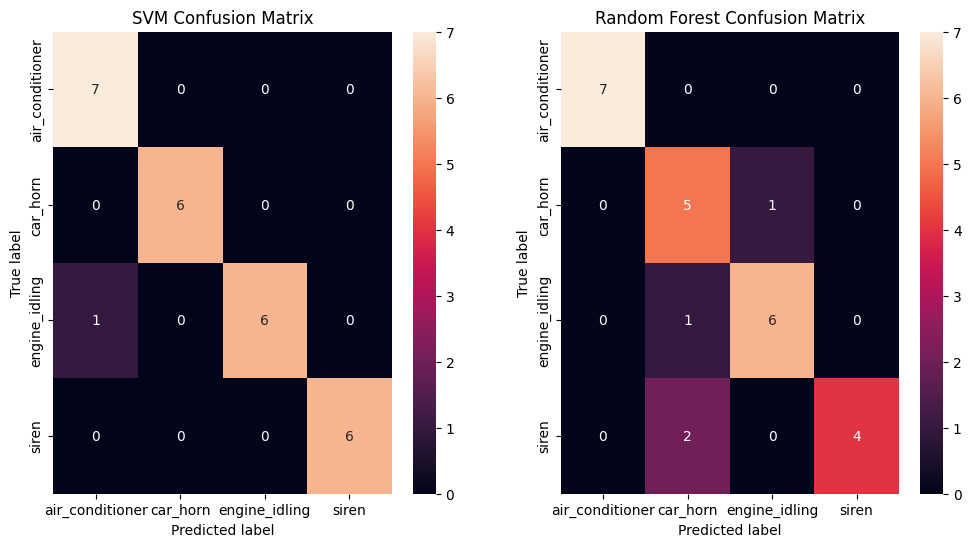

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=42, stratify=y_train_encoded)

#Linear SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

#Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_val)
y_pred_rf = rf_model.predict(X_val)

print("SVM Classification Report:")
print(classification_report(y_val, y_pred_svm, target_names=label_encoder.classes_))

print("Random Forest Classification Report:")
print(classification_report(y_val, y_pred_rf, target_names=label_encoder.classes_))

# Confusion Matrices
cm_svm = confusion_matrix(y_val, y_pred_svm)
cm_rf = confusion_matrix(y_val, y_pred_rf)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_svm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("SVM Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.subplot(1, 2, 2)
sns.heatmap(cm_rf, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Random Forest Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [6]:
test_features = [extract_features(path) for path in test['path']]

X_test = np.array(test_features)
y_test = np.array(test['label'])

y_test_encoded = label_encoder.transform(y_test)


SVM Test Classification Report:
                 precision    recall  f1-score   support

air_conditioner       0.73      1.00      0.84         8
       car_horn       1.00      1.00      1.00         8
  engine_idling       1.00      0.62      0.77         8
          siren       1.00      1.00      1.00         8

       accuracy                           0.91        32
      macro avg       0.93      0.91      0.90        32
   weighted avg       0.93      0.91      0.90        32

Random Forest Test Classification Report:
                 precision    recall  f1-score   support

air_conditioner       1.00      1.00      1.00         8
       car_horn       0.67      1.00      0.80         8
  engine_idling       1.00      0.75      0.86         8
          siren       1.00      0.75      0.86         8

       accuracy                           0.88        32
      macro avg       0.92      0.88      0.88        32
   weighted avg       0.92      0.88      0.88        32



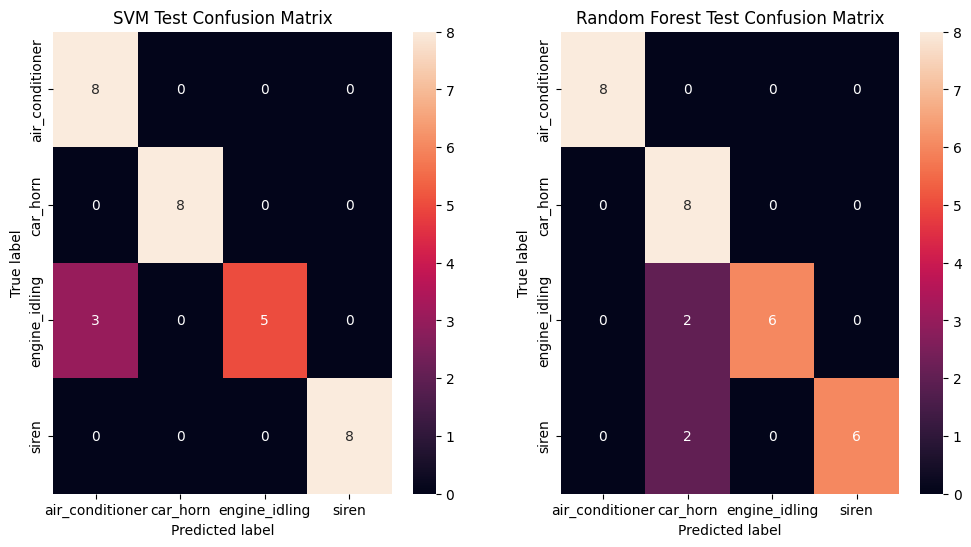

In [7]:
y_pred_svm = svm_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

print("SVM Test Classification Report:")
print(classification_report(y_test_encoded, y_pred_svm, target_names=label_encoder.classes_))

print("Random Forest Test Classification Report:")
print(classification_report(y_test_encoded, y_pred_rf, target_names=label_encoder.classes_))

cm_svm = confusion_matrix(y_test_encoded, y_pred_svm)
cm_rf = confusion_matrix(y_test_encoded, y_pred_rf)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm_svm, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("SVM Test Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.subplot(1, 2, 2)
sns.heatmap(cm_rf, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Random Forest Test Confusion Matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


## Analysis of Model Confusions and Errors in Audio Classification

### Causes of Confusion and Errors
1. **Feature Representation**
   - **Insufficiency**: Limited features may not capture all nuances necessary for distinguishing similar sounds.
   - **Normalization and Scaling**: Inadequate normalization or scaling can impact models sensitive to feature scale.

2. **Class Similarity**
   - **Inherent Similarities**: Certain audio classes may inherently sound similar, such as 'engine idling' and 'air conditioner'.
   - **Background Noises**: Similar background noises across different recordings can lead to misclassifications.

3. **Model Limitations**
   - **Linear SVM**: Struggles with complex patterns needing non-linear decision boundaries.
   - **Random Forest**: Potential overfitting if not properly tuned, affecting generalization.

4. **Data Quality and Quantity**
   - **Imbalanced Data**: Underrepresentation of certain classes can lead to inadequate learning for those classes.
   - **Variability within Classes**: Limited variability in training samples can result in poor generalization.

5. **Evaluation Metrics**
   - **Confusion Matrix Analysis**: Identifying frequent misclassifications (e.g., 'car horn' misclassified as 'siren') indicates insufficient feature distinction.


## Explanation of Signal Processing Features and Model Evaluation

### Chosen Signal Processing Features
1. **Mel-Frequency Cepstral Coefficients (MFCCs)**: Captures the timbre of the sound by modeling the shape of the auditory system's response, making it effective for distinguishing different types of sounds that have unique textural qualities.
2. **Spectral Centroid**: Indicates the "center of mass" of the sound spectrum and is used to characterize the brightness of a sound, helpful for distinguishing between sharp and dull sounds.
3. **Zero Crossing Rate (ZCR)**: Measures the rate at which the signal changes signs. This feature is useful for detecting the rhythm or the noise level in audio signals, aiding in differentiating percussive from harmonic sounds.

### Validation Techniques and Metrics
- **Confusion Matrix**: Provides a detailed breakdown of predictions versus actual classifications, helping identify specific areas where the model confuses one class for another.
- **Classification Report**: Includes precision, recall, and F1-score for each class. These metrics help assess the model’s accuracy and its ability to balance false positives and false negatives, crucial for fine-tuning performance across classes.
- **Accuracy Score**: Measures the overall correctness of the model, useful for providing a quick assessment of performance.

### Strategies for Model Improvement
- **Enhance Feature Extraction**: Incorporate additional features like Chroma (related to the musical scale) and Delta MFCCs (changes in coefficients) to capture more nuances in the audio signals.
- **Increase Data Variety**: Use data augmentation techniques like pitch shifting and adding synthetic noise to train the model on a wider array of sound scenarios.
- **Optimize Model Parameters**: Experiment with different model configurations, such as increasing the number of trees in Random Forest or using different kernels in SVM, to find the best settings for the dataset.
- **Cross-Validation**: Implement k-fold cross-validation to ensure that the model's performance is robust and generalizes well across different subsets of the dataset.

By addressing these aspects, the model's ability to accurately classify audio signals can be significantly improved.
